# note: jax and classes are tricky
still worth it imo 

https://jax.readthedocs.io/en/latest/faq.html#strategy-1-jit-compiled-helper-function

In [271]:
import jax
import jax.numpy as jnp
from jax import grad, value_and_grad, jit, vmap
from jax.scipy.stats import norm, rankdata
from jax.scipy.special import digamma
from jax.scipy.linalg import cho_factor, cho_solve
from jax.example_libraries import optimizers
from jax.scipy.linalg import cholesky
from jax import lax 
from scipy.stats import differential_entropy
import matplotlib.pyplot as plt
from jax import jit, tree_util


In [329]:
class OlfactorySensing:
    def __init__(self, N=30, n=2, M=10, P=1000, sigma_0=1e-2, sigma_c=2): 
        self.N = N
        self.n = n
        self.M = M
        self.P = P
        self.sigma_0 = sigma_0
        self.sigma_c = sigma_c
        self.set_sigma()
        self.W = None  # Initialize W as None; it may be set later with set_random_W
        self.vasicek_window = None  # This will be set when draw_cs is called

    def _tree_flatten(self):
        # Treat `W` as a dynamic value, while the rest are static
        children = (self.W,)  # W is the only dynamic value
        aux_data = {
            'N': self.N,
            'n': self.n,
            'M': self.M,
            'P': self.P,
            'sigma_0': self.sigma_0,
            'sigma_c': self.sigma_c,
            'vasicek_window': self.vasicek_window,
        }
        return (children, aux_data)

    @classmethod
    def _tree_unflatten(cls, aux_data, children):
        # Recreate an instance of OlfactorySensing from children and aux_data
        instance = cls(
            N=aux_data['N'],
            n=aux_data['n'],
            M=aux_data['M'],
            P=aux_data['P'],
            sigma_0=aux_data['sigma_0'],
            sigma_c=aux_data['sigma_c']
        )
        instance.W = children[0]
        instance.vasicek_window = aux_data['vasicek_window']
        return instance

    def set_sigma(self): 
        self.sigma = lambda x: x / (1 + x) 

    def draw_c(self, key): 
        c = jnp.zeros(self.N)
        non_zero_indices = jax.random.choice(key, self.N, shape=(self.n,), replace=False)
        concentrations = jax.random.lognormal(key, sigma=self.sigma_c, shape=(self.n,))
        c = c.at[non_zero_indices].set(concentrations)
        return c

    def draw_cs(self, key):
        keys = jax.random.split(key, self.P)
        self.vasicek_window = jax.lax.stop_gradient(jnp.round(jnp.sqrt(self.P) + 0.5)).astype(int)
        return jnp.array([self.draw_c(k) for k in keys]).T

    def set_random_W(self, key): 
        self.W = 1 / jnp.sqrt(self.N) * jax.random.normal(key, shape=(self.M, self.N))

    def compute_activity(self, W, c, key): 
        pre_activations = W @ c
        r = self.sigma(pre_activations) + self.sigma_0 * jax.random.normal(key, shape=pre_activations.shape) 
        return r
    
    def compute_entropy_of_r(self, W, key):
        c = self.draw_cs(key)
        r = self.compute_activity(W, c, key)
        entropy = self.compute_sum_of_marginal_entropies(r) - self.compute_information_of_r(r)
        return entropy

    @jit 
    def compute_sum_of_marginal_entropies(self, r):
        compute_entropy_vmap = vmap(self._vasicek_entropy, in_axes=0)
        # Apply the vectorized function
        marginal_entropies = compute_entropy_vmap(r)
        
        # Sum the marginal entropies
        return jnp.sum(marginal_entropies)
    @jit 
    def compute_information_of_r(self, r): 
        M, P = r.shape
        G = norm.ppf((rankdata(r.T, axis=0) / (P + 1)), loc=0, scale=1)
        bias_correction = 0.5 * jnp.sum(digamma((P - jnp.arange(1, M + 1) + 1) / 2) - jnp.log(P / 2))
        cov_matrix = jnp.cov(G, rowvar=False)
        chol_decomp = cholesky(cov_matrix)
        log_det = jnp.sum(jnp.log(jnp.diag(chol_decomp)))
        I = -(log_det - bias_correction)
        return I
    
    def _pad_along_last_axis(self, X):
        first_value = X[0]
        last_value = X[-1]
        # Use `lax.full_like` to create padded arrays
        Xl = lax.full_like(jnp.empty((self.vasicek_window,)), first_value)
        Xr = lax.full_like(jnp.empty((self.vasicek_window,)), last_value)
        return jnp.concatenate((Xl, X, Xr))

    def _vasicek_entropy(self, X):
        n = X.shape[-1]
        X = jnp.sort(X, axis=-1)
        X = self._pad_along_last_axis(X)
        start1 = 2 * self.vasicek_window
        length = self.P
        differences = lax.dynamic_slice(X, (start1,), (length, )) - lax.dynamic_slice(X, (0,), (length,))
        logs = jnp.log(n / (2 * self.vasicek_window) * differences)
        return jnp.mean(logs, axis=-1)

# Register the custom class as a PyTree with JAX
tree_util.register_pytree_node(
    OlfactorySensing,
    OlfactorySensing._tree_flatten,
    OlfactorySensing._tree_unflatten
)


In [330]:
os = OlfactorySensing()
key = jax.random.PRNGKey(0)
cs = os.draw_cs(key=key)
W = 1 / jnp.sqrt(os.N) * jax.random.normal(key, shape=(10, 30))
os.r = os.compute_activity(W, cs, key)
os.cs = cs 

In [331]:
os._pad_along_last_axis(os.r[0, :])

Array([0.25764543, 0.25764543, 0.25764543, ..., 0.01634433, 0.01634433,
       0.01634433], dtype=float32)

In [333]:
os.compute_entropy_of_r(W, key)

Array(12.146918, dtype=float32)

In [334]:
# Maximization with respect to W

def objective(W, key, os):
    W = W**2 # parametrize so that $W > 0$ 
    return - os.compute_entropy_of_r(W, key)  # Negate for maximization

# Set up JAX optimizer
N, M = 100, 30
os = OlfactorySensing(N=N, n=2, M=M)
key = jax.random.PRNGKey(0)
os.cs = os.draw_cs(key=key) 
W_init = 1 / jnp.sqrt(N) * jax.random.normal(key, shape=(M, N))
os.W = W_init 
opt_init, opt_update, get_params = optimizers.adam(1e-3)
opt_state = opt_init(W_init)

def step(i, opt_state, key):
    W = get_params(opt_state)
    loss, grads = value_and_grad(lambda W: objective(W, key, os))(W)
    opt_state = opt_update(i, grads, opt_state)
    return opt_state, loss  # return negative loss as the maximized entropy


In [335]:
# Run optimization
n_steps = 200
ent_values = []
for i in range(n_steps):
    key, subkey = jax.random.split(key)
    opt_state, entropy_value = step(i, opt_state, subkey)
    ent_values.append(entropy_value)
    if i % 100 == 0:
        print(f"Step {i}, Estimated Entropy: {-entropy_value}")

W_opt = jnp.sqrt(get_params(opt_state).reshape((M, N))) 
print("Optimized W:", W_opt)


Step 0, Estimated Entropy: -56.58069610595703
Step 100, Estimated Entropy: -39.397987365722656
Optimized W: [[       nan        nan        nan ...        nan 0.5155434  0.48787335]
 [0.39910188        nan 0.5196167  ...        nan 0.4071764  0.43239006]
 [0.42153436        nan 0.42899683 ... 0.5577996  0.40636328 0.49109784]
 ...
 [0.45651224        nan        nan ... 0.49156648 0.5124467         nan]
 [0.48126158 0.42940107        nan ...        nan 0.5092083  0.5057845 ]
 [0.5955872         nan        nan ...        nan 0.49985415 0.4921222 ]]


Text(0, 0.5, '-H(r)')

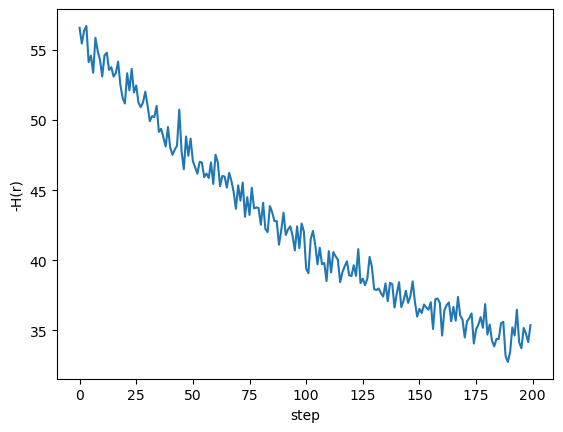

In [338]:
fig, ax = plt.subplots()
ax.plot(range(500), ent_values)
ax.set_xlabel('step') 
ax.set_ylabel('-H(r)')


In [339]:
W_init.shape

(30, 100)

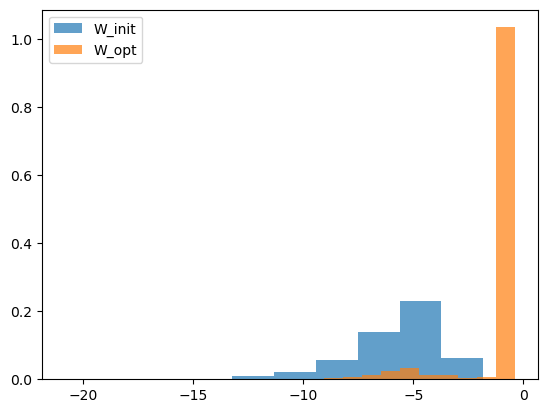

In [340]:
fig, ax = plt.subplots()
ax.hist(jnp.log(W_init.flatten()**2), label='W_init', alpha=0.7, density=True)
ax.hist(jnp.log(W_opt.flatten()), label='W_opt', alpha=0.7, density=True) 
ax.legend()

In [341]:
logw = jnp.log(W_opt) 

In [342]:
logw = jnp.nan_to_num(logw, nan=-10)

In [343]:
logw = logw.at[logw < -2].set(-10)

In [344]:
jnp.sum(logw== -10)

Array(1635, dtype=int32)

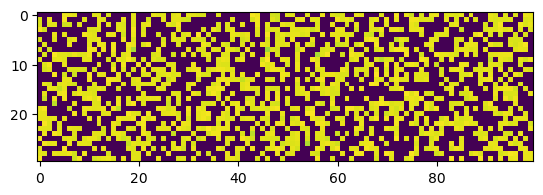

In [345]:
fig, ax = plt.subplots()
ax.imshow(logw)

Text(0.5, 0, 'log(w_opt)')

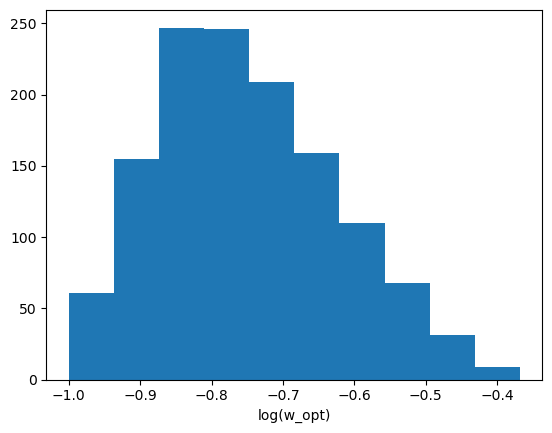

In [346]:
fig, ax = plt.subplots()
ax.hist(logw[logw > -1])
ax.set_xlabel('log(w_opt)')

# Again check that mutual information increases with covariance

In [347]:
def compute_information(c, os, P, key): 
    cov = c * jnp.ones((30, 30))
    for i in range(cov.shape[0]): 
        cov = cov.at[i, i].set(1) 
    mean = jnp.zeros(cov.shape[0])  # Assuming a zero mean, adjust as needed
    os.r = jax.random.multivariate_normal(key, mean=mean, cov=cov, shape=(P,)).T
    I = os.compute_information_of_r(os.r)
    return I

I = compute_information(0, os, 1000, key)

In [348]:
Is = []

for c in jnp.linspace(0, .9, 10): 
    I = compute_information(c, os, 1000, key)
    Is.append(I) 

Text(0, 0.5, 'MI(r)')

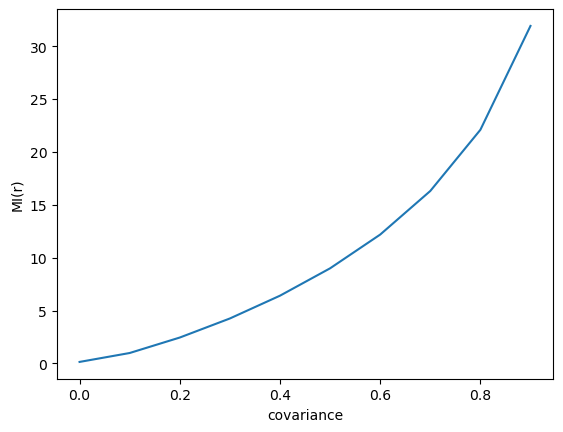

In [349]:
fig, ax = plt.subplots()
ax.plot(jnp.linspace(0, .9, 10), Is)
ax.set_xlabel('covariance') 
ax.set_ylabel('MI(r)')


Making the class a pytree: see https://jax.readthedocs.io/en/latest/faq.html#strategy-3-making-customclass-a-pytree

In [125]:
import jax.numpy as jnp
from jax import jit, tree_util

class CustomClass:
    def __init__(self, x: jnp.ndarray, mul: bool):
        self.x = x
        self.mul = mul

    @jit
    def calc(self, y):
        if self.mul:
            return self.x * y
        return y

    def _tree_flatten(self):
        children = (self.x,)  # arrays / dynamic values
        aux_data = {'mul': self.mul}  # static values
        return (children, aux_data)

    @classmethod
    def _tree_unflatten(cls, aux_data, children):
        return cls(*children, **aux_data)

# Register the custom class as a PyTree with JAX
tree_util.register_pytree_node(
    CustomClass,
    CustomClass._tree_flatten,
    CustomClass._tree_unflatten
)


In [128]:
c = CustomClass(2, True)
print(c.calc(3))  # Output should be 6

c.mul = False  # Mutation is detected
print(c.calc(3))  # Output should be 3

c = CustomClass(jnp.array(2), True)  # Non-hashable `x` (array) is supported
print(c.calc(3))  # Output should be 6



6
3
6
